In [2]:
import json
from dataclasses import dataclass, field
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn.metrics import (
    auc,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
filepath = "tfm/outputs/dataset_news_total_no" # Filepath COLAB
filepath = "https://storage.googleapis.com/tfm_aideas_datasets/dataset_news_total_no"

In [4]:
labeled_df = pd.read_csv(f"{filepath}_filters.csv", sep=";", index_col=0, parse_dates=["date"], low_memory=False, lineterminator="\n")
labeled_df.shape

(241553, 42)

In [5]:
labeled_df.sort_values(by=["date"], inplace=True)

In [6]:
# Se excluye topic_classifier debido al gran número de etiquetas:
labeled_df.topic_classifier.unique().shape

(1564,)

In [7]:
labeled_df.finanzas_tag_s_proba.describe()

count    241551.000000
mean          0.207312
std           0.200667
min           0.001001
25%           0.040703
50%           0.136108
75%           0.320792
max           0.988306
Name: finanzas_tag_s_proba, dtype: float64

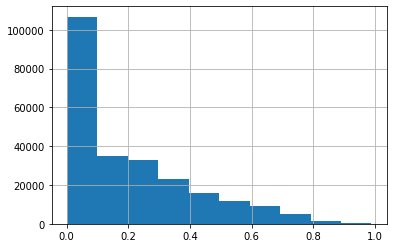

In [8]:
labeled_df.finanzas_tag_s_proba.hist()

In [9]:
labeled_df = labeled_df[(labeled_df.finanzas_tag_s_proba>=0.045)&(labeled_df.impacto_tag_s_proba>=0.15)]

In [10]:
labeled_df.shape

(156140, 42)

In [11]:
labeled_df.impacto_tag_s_proba.describe()

count    156140.000000
mean          0.345730
std           0.121607
min           0.150002
25%           0.254161
50%           0.327005
75%           0.421857
max           0.887281
Name: impacto_tag_s_proba, dtype: float64

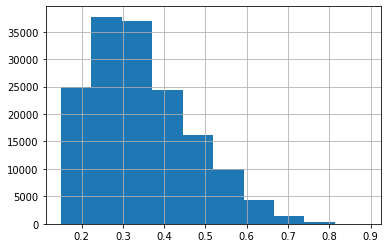

In [12]:
labeled_df.impacto_tag_s_proba.hist()

In [13]:
# labeled_df = labeled_df[labeled_df.finanzas_tag_s_proba > 0.5]
# labeled_df = labeled_df[labeled_df.intensidad > 2]

In [14]:
labeled_df.shape

(156140, 42)

In [15]:
labeled_df.vola_label.value_counts()/labeled_df.vola_label.count()

 1.0    0.398258
-1.0    0.305457
 0.0    0.296285
Name: vola_label, dtype: float64

In [16]:
labeled_df.columns.to_list()

['date',
 'title',
 'url',
 'body',
 'tags',
 'resource',
 'ticker',
 'ticker_name',
 'sector',
 'subsector',
 'ticker_freq',
 'ticker_first',
 'ticker_title',
 'tickers',
 'entities',
 'topic_classifier',
 'topics',
 'finanzas_prob',
 'sector_in_topics',
 'intensidad',
 'rd_activo_news',
 'rd_bench_news',
 'alpha_exante',
 'alpha_exante_Q1',
 'alpha_exante_below_Q1',
 'alpha_exante_Q3',
 'alpha_exante_above_Q3',
 'vola20_exante',
 'vola20_expost',
 'vola20_antepost_pct_change',
 'vola20_umbral_Q1',
 'vola20_umbral_abs_Q1',
 'vola20_umbral_Q3',
 'vola20_umbral_abs_Q3',
 'vola_label',
 'vola_label_abs',
 'body_no_entities',
 'title_no_entities',
 'impacto_tag_s_n',
 'impacto_tag_s_proba',
 'finanzas_tag_s_n',
 'finanzas_tag_s_proba']

In [20]:
include_cols = [
 'date', # antes del entrenamiento se elimina
#  'title',
#  'url',
#  'body',
#  'tags',
 'resource', # antes del entrenamiento se elimina
 'ticker', # antes del entrenamiento se elimina
#  'ticker_name',
 'sector',
#  'subsector',
 'ticker_freq',
 'ticker_first',
 'ticker_title',
#  'tickers',
#  'entities',
#  'topic_classifier',
#  'topics',
 'finanzas_prob',
 'sector_in_topics',
#  'intensidad',
#  'rd_activo_news',
#  'rd_bench_news',
 'alpha_exante',
 'alpha_exante_Q1',
 'alpha_exante_below_Q1',
 'alpha_exante_Q3',
 'alpha_exante_above_Q3',
 'vola20_exante',
#  'vola20_expost',
#  'vola20_antepost_pct_change',
#  'vola20_umbral_Q1',
#  'vola20_umbral_abs_Q1',
#  'vola20_umbral_Q3',
#  'vola20_umbral_abs_Q3',
 'vola_label',
#  'vola_label_abs',
#  'body_no_entities',
 'title_no_entities',
#  'impacto_tag_s_n',
 'impacto_tag_s_proba',
#  'finanzas_tag_s_n',
 'finanzas_tag_s_proba'
 ]

In [22]:
# labeled_df.topic_tag_news = labeled_df.topic_tag_news.replace(topics_equivalence)

In [24]:
convert_types = {
 'alpha_exante': 'float64',
 'alpha_exante_Q1': 'float64',
 'alpha_exante_Q3': 'float64',
 'alpha_exante_above_Q3': 'bool',
 'alpha_exante_below_Q1': 'bool',
 'title_no_entities': 'object',
 'date': 'datetime64[ns]',
 'finanzas_prob': 'float64',
 'finanzas_tag_s_proba': 'float64',
 'impacto_tag_s_proba': 'float64',
 'sector': 'object',
 'sector_in_topics': 'bool',
 'ticker_first': 'bool',
 'ticker_freq': 'int64',
 'ticker_title': 'bool',
 'vola20_exante': 'float64',
 'vola_label': 'int8'
 }

In [25]:
to_standardize = [
#  'date',
#  'sector',
 'ticker_freq',
#  'ticker_first',
#  'ticker_title',
#  'finanzas_prob',
#  'sector_in_topics',
 'alpha_exante',
 'alpha_exante_Q1',
#  'alpha_exante_below_Q1',
 'alpha_exante_Q3',
#  'alpha_exante_above_Q3',
 'vola20_exante',
#  'vola_label',
#  'body_no_entities',
#  'impacto_tag_s_proba',
#  'finanzas_tag_s_proba'
 ]

In [26]:
labeled_df = labeled_df.astype(convert_types)

In [27]:
# Generando las las dummies:
labeled_df = pd.get_dummies(labeled_df, columns=["sector"], drop_first=True, dtype="bool")

In [28]:
labeled_df.vola_label = labeled_df.vola_label + 1

In [30]:
#Revisar KFold con el movimiento del train split
features = labeled_df.copy()

In [31]:
labeled_df.loc[:,labeled_df.dtypes == bool] = labeled_df.loc[:,labeled_df.dtypes == bool].astype("float64")

In [32]:
# Separando los datos de train con los de validación y test con un mes de tiempo
threshold_train = int(labeled_df.shape[0]*0.8)
paragraphs_month = labeled_df.resample("M", on="date").title_no_entities.count()
mask = paragraphs_month.cumsum() < threshold_train
train_split = paragraphs_month.cumsum()[mask][-1]
val_split = paragraphs_month.cumsum()[~mask][0]
test_split = val_split + int((labeled_df.shape[0]-val_split)/2)
train = labeled_df.iloc[:train_split]
val = labeled_df.iloc[val_split:test_split]
test = labeled_df.iloc[test_split:]

In [33]:
train['date_agg'] = train.date.dt.date
#Nos quedamos con las noticias que han publicado solamente 1 vez en el dia en el mismo media para un ticker para evitar noticias contradictorias
df_grpby = train.groupby(['date_agg','ticker','resource'])
df_agg = df_grpby.agg({'ticker':'count'})
df_agg = df_agg[df_agg.ticker==1]
train = pd.merge(train, df_agg,  how='inner', left_on=['date_agg','ticker','resource'], right_index=True)
train.drop('ticker_x', axis=1, inplace=True)
train.drop('date_agg', axis=1, inplace=True)
train.drop('ticker_y', axis=1, inplace=True)
train.drop(["date", "ticker","resource"], axis=1, inplace=True)
val.drop(["date", "ticker","resource"], axis=1, inplace=True)
test.drop(["date", "ticker","resource"], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [34]:
y_train = train.vola_label.copy()
y_val = val.vola_label.copy()
y_test = test.vola_label.copy()

In [35]:
train.vola_label.value_counts()/train.vola_label.count()

2    0.401569
1    0.310202
0    0.288229
Name: vola_label, dtype: float64

In [36]:
x_train = train.drop(columns=["vola_label", "title_no_entities"])
x_val = val.drop(columns=["vola_label", "title_no_entities"])
x_test = test.drop(columns=["vola_label", "title_no_entities"])

In [37]:
ss = StandardScaler()

In [38]:
x_train[to_standardize] = ss.fit_transform(x_train[to_standardize])

In [39]:
x_val[to_standardize] = ss.transform(x_val[to_standardize])

In [40]:
x_test[to_standardize] = ss.transform(x_test[to_standardize])

Probar en cambiar el combine_feat_method de acuerdo con las siguientes modalidades:
https://multimodal-toolkit.readthedocs.io/en/latest/notes/combine_methods.html

In [44]:
# N_EPOCAS = 10
N_EPOCAS = 100

In [47]:
model = Sequential()
model.add(Dense(8, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
  )

history = model.fit(x_train.values, y_train.values, epochs=N_EPOCAS, batch_size=128, validation_data = (x_val.values, y_val.values), shuffle=False)

Epoch 1/100
270/270 [==============================] - 3s 4ms/step - loss: 1.0940 - accuracy: 0.4009 - val_loss: 1.0939 - val_accuracy: 0.4048
Epoch 2/100
270/270 [==============================] - 1s 3ms/step - loss: 1.0902 - accuracy: 0.4016 - val_loss: 1.0903 - val_accuracy: 0.4048
Epoch 3/100
270/270 [==============================] - 1s 3ms/step - loss: 1.0892 - accuracy: 0.4016 - val_loss: 1.0892 - val_accuracy: 0.4048
Epoch 4/100
270/270 [==============================] - 1s 3ms/step - loss: 1.0888 - accuracy: 0.4016 - val_loss: 1.0886 - val_accuracy: 0.4048
Epoch 5/100
270/270 [==============================] - 1s 3ms/step - loss: 1.0885 - accuracy: 0.4016 - val_loss: 1.0883 - val_accuracy: 0.4048
Epoch 6/100
270/270 [==============================] - 1s 3ms/step - loss: 1.0884 - accuracy: 0.4016 - val_loss: 1.0882 - val_accuracy: 0.4048
Epoch 7/100
270/270 [==============================] - 1s 3ms/step - loss: 1.0883 - accuracy: 0.4016 - val_loss: 1.0881 - val_accuracy: 0.4048

In [48]:
y_train.value_counts()/y_train.shape[0]

2    0.401569
1    0.310202
0    0.288229
Name: vola_label, dtype: float64

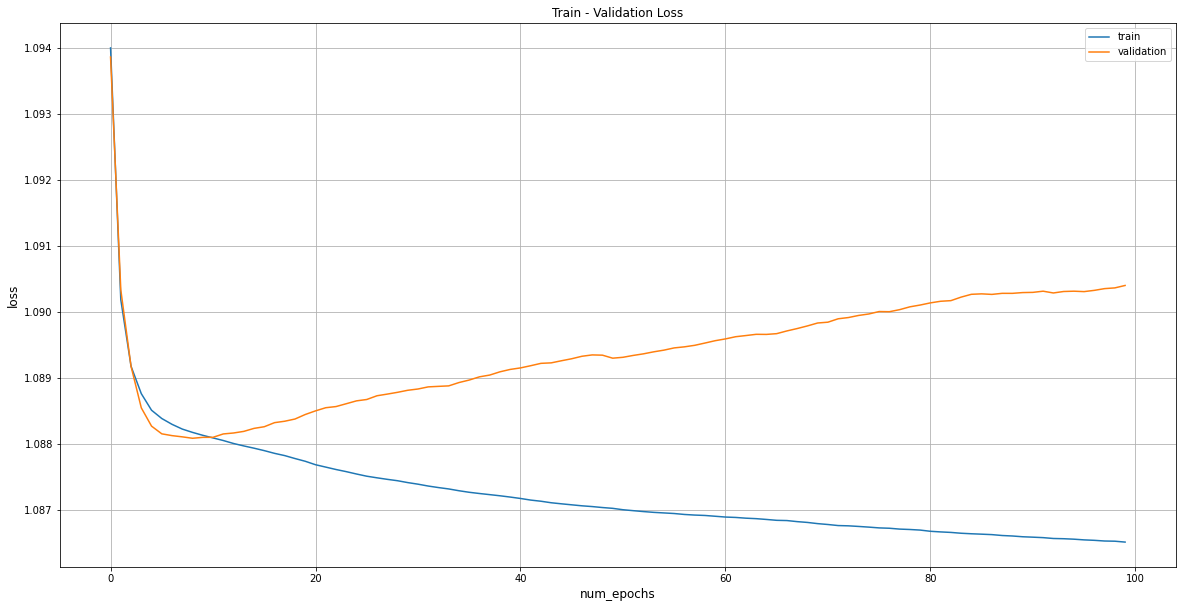

In [49]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

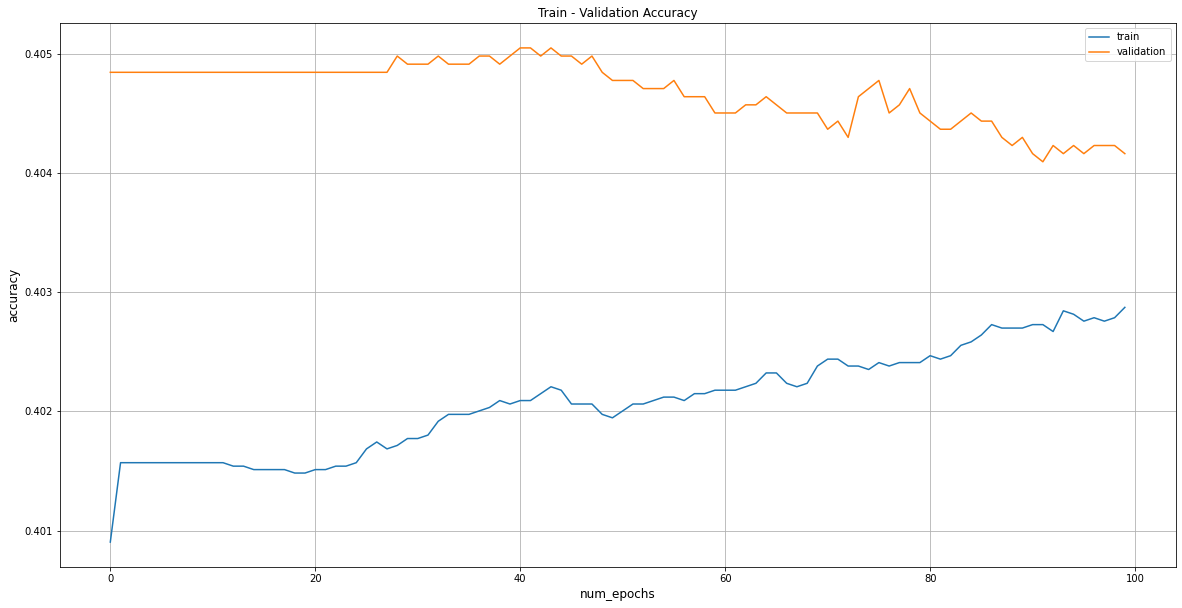

In [50]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()